In [33]:
import argparse
import random
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST

import learn2learn as l2l

In [34]:
import learn2learn as l2l

# Load MNIST and transform data
mnist = MNIST(root="/tmp/mnist", train=True, download=True)
transformations = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    lambda x: x.view(1, 28, 28),
])
print("Loading mnist_train...")
mnist_train = l2l.data.MetaDataset(MNIST('~/data',
                                         train=True,
                                         download=True,
                                         transform=transformations))
print("Loading mnist_test...")
mnist_test = l2l.data.MetaDataset(MNIST('~/data',
                                         train=False,
                                         download=True,
                                         transform=transformations))

# Create the model
ways = 10
shots = 1
tps = 5
print("Generating train_tasks...")
train_tasks = l2l.data.TaskDataset(mnist_train,
                                   task_transforms=[
                                        l2l.data.transforms.NWays(mnist_train, ways),
                                        l2l.data.transforms.KShots(mnist_train, 2*shots),
                                        l2l.data.transforms.LoadData(mnist_train),
                                        l2l.data.transforms.RemapLabels(mnist_train),
                                        l2l.data.transforms.ConsecutiveLabels(mnist_train),
                                   ],
                                   num_tasks=tps)

print("Generating test_tasks...")
test_tasks = l2l.data.TaskDataset(mnist_test,
                                   task_transforms=[
                                        l2l.data.transforms.NWays(mnist_test, ways),
                                        l2l.data.transforms.KShots(mnist_test, 2*shots),
                                        l2l.data.transforms.LoadData(mnist_test),
                                        l2l.data.transforms.RemapLabels(mnist_test),
                                        l2l.data.transforms.ConsecutiveLabels(mnist_test),
                                   ],
                                   num_tasks=tps)

Loading mnist_train...
Loading mnist_test...
Generating train_tasks...
Generating test_tasks...


In [35]:
def accuracy(predictions, targets):
    predictions = predictions.argmax(dim=1)
    acc = (predictions == targets).sum().float()
    acc /= len(targets)
    return acc.item()

In [36]:
class Net(nn.Module):
    def __init__(self, ways=3):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4 * 4 * 50, 500)
        self.fc2 = nn.Linear(500, ways)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4 * 4 * 50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [37]:
''' Implementation of standard two-level meta-learner. '''

# Define learning parameters
meta_iterations = 100
opt_steps = 10
meta_lr = 1e-3
opt_lr = 4e-3

model = Net(ways)
meta_model = l2l.algorithms.MAML(model, lr=meta_lr, first_order=False)
opt = optim.Adam(meta_model.parameters(), lr=opt_lr)
loss_func = nn.NLLLoss(reduction='mean')

losses_2layer = []
acc_2layer_train = []
acc_2layer_valid = []
acc_2layer_test = []
for iteration in range(meta_iterations):
    iteration_error = 0.0
    valid_acc = 0.0
    test_acc = 0.0
    for _ in range(tps):
        learner = meta_model.clone()
        train_task = train_tasks.sample()
        data, labels = train_task

        # Separate data into adaptation/evalutation sets
        adaptation_indices = np.zeros(data.size(0), dtype=bool)
        adaptation_indices[np.arange(shots*ways) * 2] = True
        evaluation_indices = torch.from_numpy(~adaptation_indices)
        adaptation_indices = torch.from_numpy(adaptation_indices)
        adaptation_data, adaptation_labels = data[adaptation_indices], labels[adaptation_indices]
        evaluation_data, evaluation_labels = data[evaluation_indices], labels[evaluation_indices]

        # Fast Adaptation
        train_acc = 0.0
        for step in range(opt_steps):
            train_error = loss_func(learner(adaptation_data), adaptation_labels)
            train_acc += accuracy(learner(adaptation_data), adaptation_labels)
            learner.adapt(train_error)
        acc_2layer_train.append(train_acc / opt_steps)
        
        # Compute validation loss
        predictions = learner(evaluation_data)
        valid_error = loss_func(predictions, evaluation_labels)
        valid_error /= len(evaluation_data)
        valid_accuracy = accuracy(predictions, evaluation_labels)
        iteration_error += valid_error
        valid_acc += valid_accuracy
        
        # Compute test accuracy
        test_task = test_tasks.sample()
        test_data, test_labels = test_task
        test_accuracy = accuracy(learner(test_data), test_labels)
        test_acc += test_accuracy
    
    iteration_error /= tps
    valid_acc /= tps
    test_acc /= tps
    
    losses_2layer.append(iteration_error.item())
    acc_2layer_valid.append(valid_acc)
    acc_2layer_test.append(test_acc)

    if (iteration % 10 == 0):
        print('Loss : {:.3f} Valid Acc : {:.3f} Test Acc : {:.3f}'.format(iteration_error.item(), valid_acc, test_acc))

    # Take the meta-learning step
    opt.zero_grad()
    iteration_error.backward()
    opt.step()
    
print("Final loss = ", losses_2layer[-1])
print("Final train accuracy = ", acc_2layer_train[-1])
print("Final valid accuracy= ", acc_2layer_valid[-1])
print("Final test accuracy = ", acc_2layer_test[-1])

/Users/Johanna/opt/anaconda3/lib/python3.7/site-packages/torch/tensor.py:746: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations.
  warnings.warn("The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad "


Loss : 0.230 Valid Acc : 0.180 Test Acc : 0.140
Loss : 0.035 Valid Acc : 0.860 Test Acc : 0.110
Loss : 0.099 Valid Acc : 0.880 Test Acc : 0.060
Loss : 0.096 Valid Acc : 0.640 Test Acc : 0.040
Loss : 0.475 Valid Acc : 0.240 Test Acc : 0.100
Loss : 0.134 Valid Acc : 0.600 Test Acc : 0.060
Loss : 0.069 Valid Acc : 0.940 Test Acc : 0.120
Loss : 0.057 Valid Acc : 0.940 Test Acc : 0.050
Loss : 0.031 Valid Acc : 1.000 Test Acc : 0.120
Loss : 0.022 Valid Acc : 0.960 Test Acc : 0.120
Final loss =  0.009218912571668625
Final train accuracy =  0.10000000149011612
Final valid accuracy=  1.0
Final test accuracy =  0.10000000298023223


In [38]:
''' Implementation of three-level meta-meta-learner. '''
# Define learning parameters
meta_meta_iterations = 10
meta_iterations = 10
opt_steps = 10
meta_meta_lr = 1e-4
meta_lr = 1e-3
opt_lr = 4e-3

model = Net(ways)
meta_model = l2l.algorithms.MAML(model, lr=meta_lr, first_order=False)
meta_meta_model = l2l.algorithms.MAML(meta_model, lr=meta_meta_lr, first_order=False)
opt = optim.Adam(meta_model.parameters(), lr=opt_lr)
meta_opt = optim.Adam(meta_meta_model.parameters(), lr=opt_lr)
loss_func = nn.NLLLoss(reduction='mean')

losses_3layer = []
acc_3layer_train = []
acc_3layer_valid = []
acc_3layer_test = []
for meta_iteration in range(meta_meta_iterations):
    meta_iteration_error = 0.0
    for iteration in range(meta_iterations):
        learner = meta_meta_model.clone()
        iteration_error = 0.0
        valid_acc = 0.0
        test_acc = 0.0
        for _ in range(tps):
            #learner = meta_model.clone()
            train_task = train_tasks.sample()
            data, labels = train_task

            # Separate data into adaptation/evalutation sets
            adaptation_indices = np.zeros(data.size(0), dtype=bool)
            adaptation_indices[np.arange(shots*ways) * 2] = True
            evaluation_indices = torch.from_numpy(~adaptation_indices)
            adaptation_indices = torch.from_numpy(adaptation_indices)
            adaptation_data, adaptation_labels = data[adaptation_indices], labels[adaptation_indices]
            evaluation_data, evaluation_labels = data[evaluation_indices], labels[evaluation_indices]

            # Fast Adaptation
            train_acc = 0.0
            for step in range(opt_steps):
                train_error = loss_func(learner(adaptation_data), adaptation_labels)
                train_acc += accuracy(learner(adaptation_data), adaptation_labels)
                learner.adapt(train_error)
            acc_3layer_train.append(train_acc / opt_steps)

            # Compute validation loss
            predictions = learner(evaluation_data)
            valid_error = loss_func(predictions, evaluation_labels)
            valid_error /= len(evaluation_data)
            valid_accuracy = accuracy(predictions, evaluation_labels)
            iteration_error += valid_error
            valid_acc += valid_accuracy

            # Compute test accuracy
            test_task = test_tasks.sample()
            test_data, test_labels = test_task
            test_accuracy = accuracy(learner(test_data), test_labels)
            test_acc += test_accuracy

        iteration_error /= tps
        valid_acc /= tps
        test_acc /= tps
        
        meta_iteration_error += iteration_error
        
        losses_3layer.append(iteration_error.item())
        acc_3layer_valid.append(valid_acc)
        acc_3layer_test.append(test_acc)

        if (iteration % 10 == 0):
            print('Loss : {:.3f} Valid Acc : {:.3f} Test Acc : {:.3f}'.format(iteration_error.item(), valid_acc, test_acc))

        # Take the meta-learning step
        opt.zero_grad()
        iteration_error.backward(retain_graph=True)
        opt.step()
        
    meta_iteration_error /= meta_iterations
        
    # Take the meta_meta-learning step
    meta_opt.zero_grad()
    meta_iteration_error.backward()
    meta_opt.step()
    
print("Final loss = ", losses_3layer[-1])
print("Final train accuracy = ", acc_3layer_train[-1])
print("Final valid accuracy= ", acc_3layer_valid[-1])
print("Final test accuracy = ", acc_3layer_test[-1])

Loss : 0.231 Valid Acc : 0.020 Test Acc : 0.120
Loss : 0.100 Valid Acc : 0.780 Test Acc : 0.100
Loss : 0.033 Valid Acc : 0.880 Test Acc : 0.090
Loss : 0.057 Valid Acc : 0.920 Test Acc : 0.070
Loss : 0.011 Valid Acc : 0.940 Test Acc : 0.090
Loss : 0.009 Valid Acc : 0.960 Test Acc : 0.100
Loss : 0.000 Valid Acc : 1.000 Test Acc : 0.110
Loss : 0.026 Valid Acc : 0.920 Test Acc : 0.090
Loss : 0.000 Valid Acc : 1.000 Test Acc : 0.130
Loss : 0.001 Valid Acc : 1.000 Test Acc : 0.090
Final loss =  1.9867750324920053e-06
Final train accuracy =  0.20000000298023224
Final valid accuracy=  1.0
Final test accuracy =  0.15000000223517418


In [39]:
''' Implementation of four-level meta-meta-learner. '''
# Define learning parameters
meta3_iterations = 10
meta2_iterations = 1
meta_iterations = 10
opt_steps = 10
meta3_lr = 1e-5
meta2_lr = 1e-4
meta_lr = 1e-3
opt_lr = 4e-3

model = Net(ways)
meta1_model = l2l.algorithms.MAML(model, lr=meta_lr, first_order=False)
meta2_model = l2l.algorithms.MAML(meta1_model, lr=meta2_lr, first_order=False)
meta3_model = l2l.algorithms.MAML(meta2_model, lr=meta3_lr, first_order=False)
opt = optim.Adam(meta1_model.parameters(), lr=opt_lr)
meta2_opt = optim.Adam(meta2_model.parameters(), lr=opt_lr)
meta3_opt = optim.Adam(meta3_model.parameters(), lr=opt_lr)
loss_func = nn.NLLLoss(reduction='mean')

losses_4layer = []
acc_4layer_train = []
acc_4layer_valid = []
acc_4layer_test = []
for meta3_iteration in range(meta3_iterations):
    meta3_iteration_error = 0.0
    for meta2_iteration in range(meta2_iterations):
        meta2_iteration_error = 0.0
        for iteration in range(meta_iterations):
            learner = meta3_model.clone()
            iteration_error = 0.0
            valid_acc = 0.0
            test_acc = 0.0
            for _ in range(tps):
                #learner = meta_model.clone()
                train_task = train_tasks.sample()
                data, labels = train_task

                # Separate data into adaptation/evalutation sets
                adaptation_indices = np.zeros(data.size(0), dtype=bool)
                adaptation_indices[np.arange(shots*ways) * 2] = True
                evaluation_indices = torch.from_numpy(~adaptation_indices)
                adaptation_indices = torch.from_numpy(adaptation_indices)
                adaptation_data, adaptation_labels = data[adaptation_indices], labels[adaptation_indices]
                evaluation_data, evaluation_labels = data[evaluation_indices], labels[evaluation_indices]

                # Fast Adaptation
                train_acc = 0.0
                for step in range(opt_steps):
                    train_error = loss_func(learner(adaptation_data), adaptation_labels)
                    train_acc += accuracy(learner(adaptation_data), adaptation_labels)
                    learner.adapt(train_error)
                acc_4layer_train.append(train_acc / opt_steps)

                # Compute validation loss
                predictions = learner(evaluation_data)
                valid_error = loss_func(predictions, evaluation_labels)
                valid_error /= len(evaluation_data)
                valid_accuracy = accuracy(predictions, evaluation_labels)
                iteration_error += valid_error
                valid_acc += valid_accuracy

                # Compute test accuracy
                test_task = test_tasks.sample()
                test_data, test_labels = test_task
                test_accuracy = accuracy(learner(test_data), test_labels)
                test_acc += test_accuracy

            iteration_error /= tps
            valid_acc /= tps
            test_acc /= tps

            meta2_iteration_error += iteration_error

            losses_4layer.append(iteration_error.item())
            acc_4layer_valid.append(valid_acc)
            acc_4layer_test.append(test_acc)

            if (iteration % 10 == 0):
                print('Loss : {:.3f} Valid Acc : {:.3f} Test Acc : {:.3f}'.format(iteration_error.item(), valid_acc, test_acc))

            # Take the meta-learning step
            opt.zero_grad()
            iteration_error.backward(retain_graph=True)
            opt.step()

        meta2_iteration_error /= meta2_iterations
        meta3_iteration_error += meta2_iteration_error

        # Take the meta2-learning step
        meta2_opt.zero_grad()
        meta2_iteration_error.backward(retain_graph=True)
        meta2_opt.step()
        
        
    meta3_iteration_error /= meta3_iterations

    # Take the meta3-learning step
    meta3_opt.zero_grad()
    meta3_iteration_error.backward()
    meta3_opt.step()
    
print("Final loss = ", losses_4layer[-1])
print("Final train accuracy = ", acc_4layer_train[-1])
print("Final valid accuracy= ", acc_4layer_valid[-1])
print("Final test accuracy = ", acc_4layer_test[-1])

Loss : 0.230 Valid Acc : 0.100 Test Acc : 0.100
Loss : 0.722 Valid Acc : 0.300 Test Acc : 0.060
Loss : 0.115 Valid Acc : 0.540 Test Acc : 0.120
Loss : 0.118 Valid Acc : 0.800 Test Acc : 0.060
Loss : 0.007 Valid Acc : 0.980 Test Acc : 0.030
Loss : 0.001 Valid Acc : 1.000 Test Acc : 0.100
Loss : 0.000 Valid Acc : 1.000 Test Acc : 0.090
Loss : 0.000 Valid Acc : 1.000 Test Acc : 0.060
Loss : 0.000 Valid Acc : 1.000 Test Acc : 0.050
Loss : 0.000 Valid Acc : 1.000 Test Acc : 0.110
Final loss =  4.839088433072902e-06
Final train accuracy =  0.30000001192092896
Final valid accuracy=  1.0
Final test accuracy =  0.05000000074505806


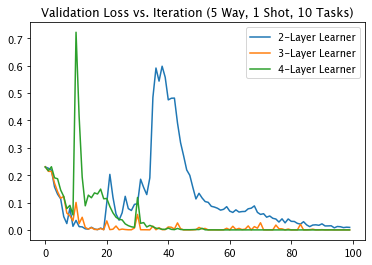

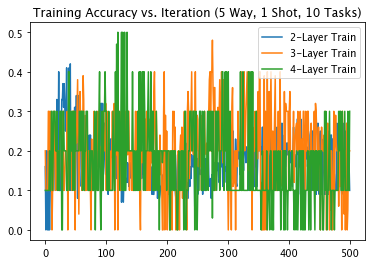

<function matplotlib.pyplot.show(*args, **kw)>

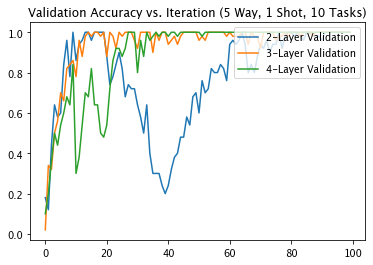

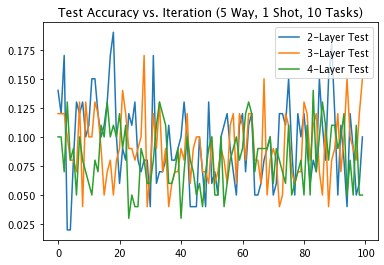

In [40]:
import matplotlib.pyplot as plt
%matplotlib inline

''' Compare Performances '''
# Plot Loss
plt.figure()
plt.plot(np.arange(0, len(losses_2layer), 1), losses_2layer, '-', label="2-Layer Learner")
plt.plot(np.arange(0, len(losses_3layer), 1), losses_3layer, '-', label="3-Layer Learner")
plt.plot(np.arange(0, len(losses_4layer), 1), losses_4layer, '-', label="4-Layer Learner")
plt.legend(loc="upper right")
plt.title("Validation Loss vs. Iteration (5 Way, 1 Shot, 10 Tasks)")
plt.show

# Plot Accuracy
plt.figure()
plt.plot(np.arange(0, len(acc_2layer_train), 1), acc_2layer_train, '-', label="2-Layer Train")
plt.plot(np.arange(0, len(acc_3layer_train), 1), acc_3layer_train, '-', label="3-Layer Train")
plt.plot(np.arange(0, len(acc_4layer_train), 1), acc_4layer_train, '-', label="4-Layer Train")
plt.legend(loc="upper right")
plt.title("Training Accuracy vs. Iteration (5 Way, 1 Shot, 10 Tasks)")
plt.show()

plt.figure()
plt.plot(np.arange(0, len(acc_2layer_valid), 1), acc_2layer_valid, '-', label="2-Layer Validation")
plt.plot(np.arange(0, len(acc_3layer_valid), 1), acc_3layer_valid, '-', label="3-Layer Validation")
plt.plot(np.arange(0, len(acc_4layer_valid), 1), acc_4layer_valid, '-', label="4-Layer Validation")
plt.legend(loc="upper right")
plt.title("Validation Accuracy vs. Iteration (5 Way, 1 Shot, 10 Tasks)")
plt.show

plt.figure()
plt.plot(np.arange(0, len(acc_2layer_test), 1), acc_2layer_test, '-',label="2-Layer Test")
plt.plot(np.arange(0, len(acc_3layer_test), 1), acc_3layer_test, '-', label="3-Layer Test")
plt.plot(np.arange(0, len(acc_4layer_test), 1), acc_4layer_test, '-', label="4-Layer Test")
plt.legend(loc="upper right")
plt.title("Test Accuracy vs. Iteration (5 Way, 1 Shot, 10 Tasks)")
plt.show